In [24]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt
from datetime import timedelta as td
import warnings

In [25]:
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = None 

### import the cleaned csv files 

In [26]:
jobs = pd.read_csv("../data/jobs_data.csv")

In [27]:
logs_sbatch = pd.read_csv("../data/slurm_sbatch.csv")

### Convert appropriate values to datetime and sort values 

In [28]:
logs_sbatch['DATE'] = pd.to_datetime(logs_sbatch['DATE'])
logs_sbatch = logs_sbatch.sort_values('DATE')

jobs['END'] = pd.to_datetime(jobs['END'])

In [29]:
jobs_completed = jobs[jobs['STATE'] ==  'COMPLETED']
jobs_completed.head()

jobs_failed = jobs[jobs['STATE'] !=  'COMPLETED']

### Splitting logs_sbatch to timeout and complete categories

In [30]:
logs_timeout = logs_sbatch[(logs_sbatch['RETURNCODE'] == 1) & (logs_sbatch['TIME'] > 15)]
logs_testing = logs_sbatch[(logs_sbatch['RETURNCODE'] == 0) & (logs_sbatch['TIME'] <= 15)]

In [31]:
#filter out scheduled maintenance 
logs_timeout = logs_timeout[(logs_timeout['DATE'] < '2021-05-16') | (logs_timeout['DATE'] > '2021-05-29')]

logs_testing = logs_testing[(logs_testing['DATE'] < '2021-05-16') | (logs_testing['DATE'] > '2021-05-29')]

### Adding rolling avg columns to logs files

In [32]:
logs_timeout['ROLL1HOUR'] = (logs_timeout.rolling('1h', on='DATE')['UNRESPONSIVE'].count())
logs_testing['ROLL1HOUR'] = (logs_testing.rolling('1h', on='DATE')['TESTING'].count())
logs_timeout['ROLL24HOUR'] = (logs_timeout.rolling('24h', on='DATE')['UNRESPONSIVE'].count())
logs_testing['ROLL24HOUR'] = (logs_testing.rolling('24h', on='DATE')['TESTING'].count())

### Making per week groupby dataframes for jogs and two logs dfs
#### Also making columns to merge on

In [62]:
jobs_weekly = jobs.groupby(pd.Grouper(key='END', freq='W'))['JOBID'].count()/168
jobs_weekly = jobs_weekly.reset_index()

jobs_completed_weekly = jobs_completed.groupby(pd.Grouper(key='END', freq='W'))['JOBID'].count()/168
jobs_completed_weekly = jobs_completed_weekly.reset_index()
jobs_completed_weekly = jobs_completed_weekly.rename(columns={'JOBID':'JOBID_COMP'})


jobs_failed_weekly = jobs_failed.groupby(pd.Grouper(key='END', freq='W'))['JOBID'].count()/168
jobs_failed_weekly = jobs_failed_weekly.reset_index()
jobs_failed_weekly = jobs_failed_weekly.rename(columns={'JOBID':'JOBID_FAIL'})


In [63]:
jobs_weekly = jobs_weekly.rename(columns={'END':'DATE'})
jobs_failed_weekly = jobs_failed_weekly.rename(columns={'END':'DATE'})
jobs_completed_weekly = jobs_completed_weekly.rename(columns={'END':'DATE'})

In [64]:
logs_timeouts_by_week = logs_timeout.groupby(pd.Grouper(key='DATE', freq='W'))['UNRESPONSIVE'].count()/168
logs_timeouts_by_week = logs_timeouts_by_week.reset_index()

logs_testing_by_week = logs_testing.groupby(pd.Grouper(key='DATE', freq='W'))['TESTING'].count()/168
logs_testing_by_week = logs_testing_by_week.reset_index()

In [65]:
jobs_logs_weekly = pd.merge(logs_timeouts_by_week, logs_testing_by_week, on='DATE')
jobs_logs_weekly = pd.merge(jobs_logs_weekly, jobs_weekly, on='DATE')
jobs_logs_weekly = pd.merge(jobs_logs_weekly, jobs_failed_weekly, on='DATE')
jobs_logs_weekly = pd.merge(jobs_logs_weekly, jobs_completed_weekly, on='DATE')

In [86]:
jobs_logs_weekly.head()

,DATE,UNRESPONSIVE,TESTING,JOBID,JOBID_FAIL,JOBID_COMP
0,2020-10-18,0.107143,3.720238,673.851190,1.178571,672.672619
1,2020-10-25,0.172619,7.922619,1457.952381,1.446429,1456.505952
2,2020-11-01,0.035714,7.523810,611.309524,1.291667,610.017857
3,2020-11-08,0.011905,7.351190,363.738095,4.065476,359.672619
4,2020-11-15,0.208333,7.345238,756.119048,3.994048,752.125000


[Text(0.5, 1.0, 'Logs Comp./Fail v All Jobs'), Text(0, 0.5, 'Number of Jobs')]

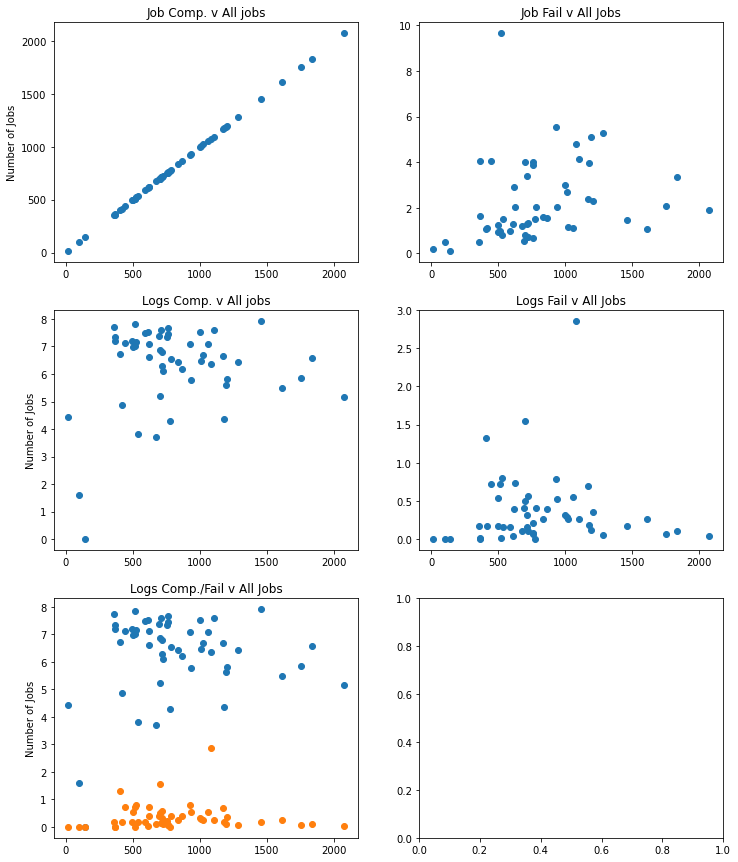

In [102]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

ax[0, 0].scatter(jobs_logs_weekly['JOBID'], jobs_logs_weekly['JOBID_COMP'])
ax[0, 0].set(title='Job Comp. v All jobs', ylabel="Number of Jobs")
ax[0, 1].scatter(jobs_logs_weekly['JOBID'], jobs_logs_weekly['JOBID_FAIL'])
ax[0, 1].set(title='Job Fail v All Jobs')

ax[1, 0].scatter(jobs_logs_weekly['JOBID'], jobs_logs_weekly['TESTING'])
ax[1, 0].set(title='Logs Comp. v All jobs', ylabel="Number of Jobs")
ax[1, 1].scatter(jobs_logs_weekly['JOBID'], jobs_logs_weekly['UNRESPONSIVE'])
ax[1, 1].set(title='Logs Fail v All Jobs')

ax[2, 0].scatter(jobs_logs_weekly['JOBID'], jobs_logs_weekly['TESTING'])
ax[2, 0].scatter(jobs_logs_weekly['JOBID'], jobs_logs_weekly['UNRESPONSIVE'])
ax[2, 0].set(title='Logs Comp./Fail v All Jobs', ylabel="Number of Jobs")

[Text(0.5, 1.0, 'Total Jobs v Unsuccessful Logs')]

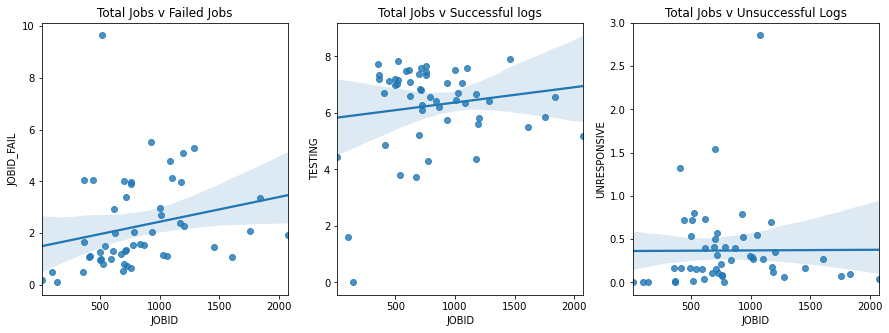

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))


sns.regplot(jobs_logs_weekly['JOBID'], jobs_logs_weekly['JOBID_FAIL'],ax=ax[0])
ax[0].set(title='Total Jobs v Failed Jobs')
sns.regplot(jobs_logs_weekly['JOBID'], jobs_logs_weekly['TESTING'],ax=ax[1])
ax[1].set(title='Total Jobs v Successful logs')
sns.regplot(jobs_logs_weekly['JOBID'], jobs_logs_weekly['UNRESPONSIVE'],ax=ax[2])
ax[2].set(title='Total Jobs v Unsuccessful Logs')